In [16]:
import pickle
from pathlib import Path
import glob, os, re, sys
sys.path.append('../')

import configparser

import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d

import astro_helper as ah
import PRFM_helper as ph

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

# Load the data

In [2]:
titles = ['MW']

In [3]:
def get_image_data(filename):
    with open(filename, "rb") as f:
        xpix = np.fromfile(f, dtype=np.int32, count=1)[0]
        ypix = np.fromfile(f, dtype=np.int32, count=1)[0]
        img = np.fromfile(f, dtype=np.float32, count=xpix*ypix)
    img = np.reshape(img, (xpix, ypix))
    return img

## PRFM, unresolved

In [4]:
# SH03 files
dirs_PRFM = [
    '/LOW-ETGs/vlM-PRFM/',
    '/LOW-ETGs/lowM-PRFM/',
    '/LOW-ETGs/medM-PRFM/',
    '/LOW-ETGs/hiM-PRFM/',
    '/LtU/LOW-PRFM/'
]
tau_deps_PRFM, tau_dyns_PRFM, SFRs_PRFM = [], [], []
for dir_PRFM in dirs_PRFM:
    filenames_Sfr = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/Sfr_proj_*'),
                           key=lambda x: int(x.split('_')[-1])) # Msol/kpc^2/yr
    filenames_Veldisp = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/Veldisp_proj_*'),
                                key=lambda x: int(x.split('_')[-1]))
    filenames_PDE = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/PDE_proj_*'),
                            key=lambda x: int(x.split('_')[-1]))
    filenames_Sigmagas = sorted(glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM+'/output/density_proj_*'),
                                key=lambda x: int(x.split('_')[-1])) # 10^9 Msol/kpc^2

    # load all as a flat raveled array
    testfile = get_image_data(filenames_Sfr[0])
    Sfrs = np.array([np.ravel(get_image_data(file)) for file in filenames_Sfr]).flatten()
    Veldisps = np.array([np.ravel(get_image_data(file)) for file in filenames_Veldisp]).flatten()
    PDEs = np.array([np.ravel(get_image_data(file)) for file in filenames_PDE]).flatten()
    Sigmagas = np.array([np.ravel(get_image_data(file)) for file in filenames_Sigmagas]).flatten()

    # depletion time, something to do with how projected values are calculated?
    if dir_PRFM == '/LtU/LOW-PRFM/':
        tau_deps = Sigmagas * 0.08**2 / Sfrs
    else:
        tau_deps = Sigmagas * 10. * 0.08**2 / Sfrs
    tau_deps_PRFM.append(tau_deps)
    SFRs_PRFM.append(Sfrs)

    # dynamical time, probably out by some kB factor in internal units
    if dir_PRFM == '/LtU/LOW-PRFM/':
        arepo_mass_unit = 1.e9
    else:
        arepo_mass_unit = 1.e10
    press_unit = arepo_mass_unit*1.99e33*(1.e5)**2/(3.086e21)**3
    Sigma_unit = arepo_mass_unit*1.99e33/(3.086e21)**2
    Veldisp_unit = 1.e5
    tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
    tau_dyns_PRFM.append(tau_dyns)

/tmp/ipykernel_3987401/1748090675.py:31: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 10. * 0.08**2 / Sfrs
/tmp/ipykernel_3987401/1748090675.py:43: RuntimeWarning: invalid value encountered in divide
  tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
/tmp/ipykernel_3987401/1748090675.py:29: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 0.08**2 / Sfrs


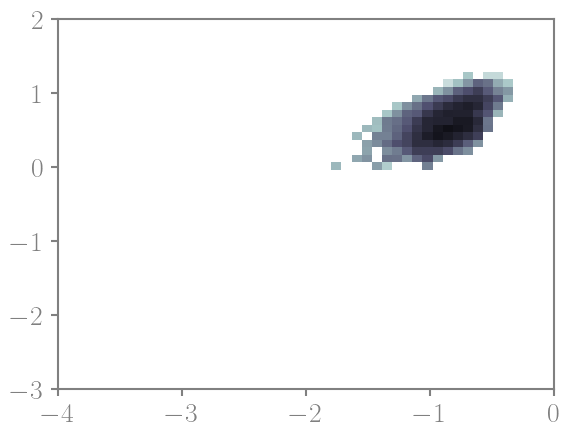

In [5]:
# scatter against each other
i = 0
tau_deps, tau_dyns, SFRs = tau_deps_PRFM[i], tau_dyns_PRFM[i], SFRs_PRFM[i]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
plt.imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
plt.show()

## PRFM, resolved

In [6]:
dirs_PRFM_r = [
    '/LOW-ETGs/vlM-PRFM-res/',
    '/LOW-ETGs/lowM-PRFM-res/',
    '/LOW-ETGs/medM-PRFM-res/',
    '/LOW-ETGs/hiM-PRFM-res/',
    '/LtU/LOW-PRFM_RSLVD/'
]
tau_deps_PRFM_r, tau_dyns_PRFM_r, SFRs_PRFM_r = [], [], []
for dir_PRFM_r in dirs_PRFM_r:
    filenames_Sfr = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/Sfr_proj_*') # Msol/kpc^2/yr
    filenames_Veldisp = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/Veldisp_proj_*')
    filenames_PDE = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/PDE_proj_*')
    filenames_Sigmagas = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_PRFM_r+'/output/density_proj_*') # 10^9 Msol/kpc^2

    files_Sfr = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sfr], filenames_Sfr))]
    files_Veldisp = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Veldisp], filenames_Veldisp))]
    files_PDE = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_PDE], filenames_PDE))]
    files_Sigmagas = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sigmagas], filenames_Sigmagas))]

    # load all as a flat raveled array
    Sfrs = np.array([np.ravel(get_image_data(file)) for file in files_Sfr]).flatten()
    Veldisps = np.array([np.ravel(get_image_data(file)) for file in files_Veldisp]).flatten()
    PDEs = np.array([np.ravel(get_image_data(file)) for file in files_PDE]).flatten()
    Sigmagas = np.array([np.ravel(get_image_data(file)) for file in files_Sigmagas]).flatten()

    # depletion time, something to do with how projected values are calculated?
    if dir_PRFM_r=='/LtU/LOW-PRFM_RSLVD/':
        tau_deps = Sigmagas * 0.08**2 / Sfrs
    else:
        tau_deps = Sigmagas * 10. * 0.08**2 / Sfrs
    tau_deps_PRFM_r.append(tau_deps)
    SFRs_PRFM_r.append(Sfrs)

    # dynamical time, probably out by some kB factor in internal units
    if dir_PRFM_r=='/LtU/LOW-PRFM_RSLVD/':
        arepo_mass_unit = 1.e9
    else:
        arepo_mass_unit = 1.e10
    press_unit = arepo_mass_unit*1.99e33*(1.e5)**2/(3.086e21)**3
    Sigma_unit = arepo_mass_unit*1.99e33/(3.086e21)**2
    Veldisp_unit = 1.e5
    tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
    tau_dyns_PRFM_r.append(tau_dyns)

/tmp/ipykernel_3987401/4104979170.py:30: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 10. * 0.08**2 / Sfrs
/tmp/ipykernel_3987401/4104979170.py:42: RuntimeWarning: invalid value encountered in divide
  tau_dyns = (Sigmagas*Sigma_unit * Veldisps*Veldisp_unit / (PDEs*press_unit)) / ah.Gyr_to_s
/tmp/ipykernel_3987401/4104979170.py:28: RuntimeWarning: divide by zero encountered in divide
  tau_deps = Sigmagas * 0.08**2 / Sfrs


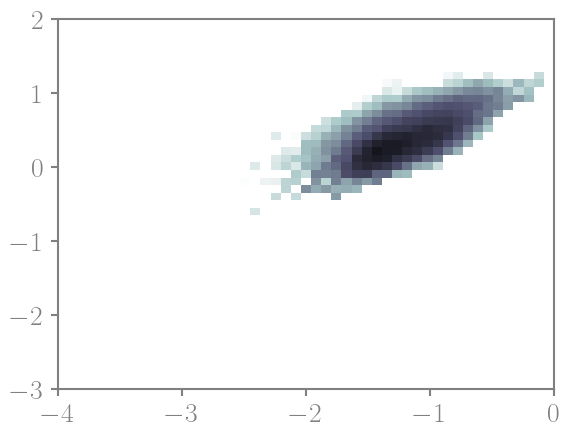

In [7]:
# scatter against each other
tau_deps, tau_dyns, SFRs = tau_deps_PRFM_r[0], tau_dyns_PRFM_r[0], SFRs_PRFM_r[0]
frac_SFR, _, _, _ = binned_statistic_2d(
    np.log10(tau_dyns), np.log10(tau_deps),
    SFRs, statistic='sum',
    bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
)
frac_SFR /= np.sum(frac_SFR)
plt.imshow(frac_SFR.T, origin='lower',
                 extent=(-4., 0., -3., 2.), aspect='auto',
                 cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
plt.show()

## Springel & Hernquist 03

In [8]:
# dirs_SH03 = [
#     '/LtU/LOW-SH03/'
# ]
# tags = ['MW']

# tau_deps_SH03, tau_dyns_SH03, SFRs_SH03 = [], [], []
# for tag, dir_SH03 in zip(tags, dirs_SH03):
#     # depletion times
#     filenames_Sfr = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/Sfr_proj_*') # Msol/kpc^2/yr
#     filenames_temp = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/temp_proj_*')
#     filenames_Sigmagas = glob.glob('/n/holystore01/LABS/itc_lab/Users/sjeffreson/'+dir_SH03+'/output/density_proj_*') # 10^9 Msol/kpc^2

#     files_Sfr = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sfr], filenames_Sfr))]
#     files_temp = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_temp], filenames_temp))]
#     files_Sigmagas = [x for _, x in sorted(zip([int(re.search(r'\d+', x).group()) for x in filenames_Sigmagas], filenames_Sigmagas))]

#     # load all as a flat raveled array
#     Sfrs = np.array([np.ravel(get_image_data(file)) for file in files_Sfr]).flatten()
#     temps = np.array([np.ravel(get_image_data(file)) for file in files_temp]).flatten()
#     Sigmagas = np.array([np.ravel(get_image_data(file)) for file in files_Sigmagas]).flatten()

#     # depletion time, something to do with how projected values are calculated?
#     tau_deps = Sigmagas * 0.08**2 / Sfrs
#     tau_deps_SH03.append(tau_deps)
#     SFRs_SH03.append(Sfrs)

#     # dynamical times
#     tag = 'MW'
#     config = configparser.ConfigParser()
#     config.read('../../GalactISM/config_prfm-check.ini')

#     prfm_array = min(glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + '/prfm_*.pkl'))

#     with open(prfm_array, "rb") as f:
#         prfm_dict = pickle.load(f)
#         star_surfdens = np.ravel(prfm_dict['star_surfdens'])
#         Omega = np.ravel(prfm_dict['Omega'])

#     # dynamical time, probably out by some kB factor in internal units
#     Sigmagas *= 1.e9 * ah.Msol_to_g / (ah.kpc_to_cm)**2
#     Utherm = (temps * ah.kB_cgs) / (ah.gamma - 1.0)
#     Sigma_gs = Sigmagas + star_surfdens
#     PDE = (ah.gamma - 1.0) * Utherm # initialize
#     sigmaEff = 12. * ah.kms_to_cms # initialize
#     i = 0
#     while i < 5:
#         print(np.nanmedian(PDE/ah.kB_cgs), np.nanmedian(sigmaEff/1.e5))
#         PDE = Sigmagas / 4. * (np.pi * ah.G_cgs * Sigma_gs + ((np.pi * ah.G_cgs)**2 * Sigma_gs**2 + 8./3. * Omega**2 * sigmaEff**2)**0.5)
#         sigmaEff = 12. * ah.kms_to_cms * (PDE / (1.e4 * ah.kB_cgs))**(0.22)
#         i += 1

#     tau_dyn = Sigmagas * sigmaEff / PDE / ah.Gyr_to_s
#     tau_dyns_SH03.append(tau_dyn)

In [9]:
# # scatter against each other
# tau_deps, tau_dyns, SFRs = tau_deps_SH03[0], tau_dyns_SH03[0], SFRs_SH03[0]
# frac_SFR, _, _, _ = binned_statistic_2d(
#     np.log10(tau_dyns), np.log10(tau_deps),
#     SFRs, statistic='sum',
#     bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
# )
# frac_SFR /= np.sum(frac_SFR)
# plt.imshow(frac_SFR.T, origin='lower',
#                  extent=(-4., 0., -3., 2.), aspect='auto',
#                  cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-5, vmax=1.e-1))
# plt.show()

## high-resolution galaxies

In [10]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW']

In [13]:
tau_deps_hr, tau_dyns_hr, Sigma_SFRs_hr = [], [], []
for tag in tags:
    print(tag)
    config = configparser.ConfigParser()
    config.read('../../GalactISM/config_Forces.ini')

    allgas_arrays = glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + '/allgas_*.pkl')
    allgas_nos = [arr.rsplit('_' + tag)[0].rsplit('allgas_')[1] for arr in allgas_arrays]
    allgas_arrays = [arr for _, arr in sorted(zip(allgas_nos, allgas_arrays))]

    coolgas_arrays = glob.glob(str(Path(config[tag]['ROOT_DIR']) / Path(config[tag]['SUBDIR'])) + "/coolgas_*T2.0e+04_avir2.0e+00.pkl")
    coolgas_nos = [arr.rsplit('_' + tag)[0].rsplit('coolgas_')[1] for arr in coolgas_arrays]
    coolgas_arrays = [arr for _, arr in sorted(zip(coolgas_nos, coolgas_arrays))]

    tau_deps_hr_, tau_dyns_hr_, Sigma_SFRs_hr_ = [], [], []
    for allgas_array, coolgas_array in zip(allgas_arrays, coolgas_arrays):
        with open(allgas_array, "rb") as f:
            allgas_dict = pickle.load(f)
        with open(coolgas_array, "rb") as f:
            coolgas_dict = pickle.load(f)

        # depletion times
        tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']
        Sigma_SFR = allgas_dict['SFR_surfdens']
        cnd = (tau_dep > 0) & ~np.isinf(tau_dep)
        tau_deps_hr_.extend(tau_dep[cnd])
        Sigma_SFRs_hr_.extend(Sigma_SFR[cnd])

        # dynamical times
        tau_dyn = allgas_dict['gas_surfdens'] * coolgas_dict['veldisp_midplane'] / (coolgas_dict['Pturb'] + coolgas_dict['Ptherm'])
        tau_dyns_hr_.extend(tau_dyn[cnd])

    tau_deps_hr.append(np.array(tau_deps_hr_))
    tau_dyns_hr.append(np.array(tau_dyns_hr_))
    Sigma_SFRs_hr.append(np.array(Sigma_SFRs_hr_))


ETG-vlM


/tmp/ipykernel_3987401/3416167521.py:23: RuntimeWarning: divide by zero encountered in divide
  tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']
/tmp/ipykernel_3987401/3416167521.py:23: RuntimeWarning: invalid value encountered in divide
  tau_dep = allgas_dict['gas_surfdens'] / allgas_dict['SFR_surfdens']


ETG-lowM
ETG-medM
ETG-hiM
MW


# figure

/tmp/ipykernel_3987401/779316364.py:9: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),
/tmp/ipykernel_3987401/779316364.py:24: RuntimeWarning: invalid value encountered in log10
  np.log10(tau_dyns), np.log10(tau_deps),


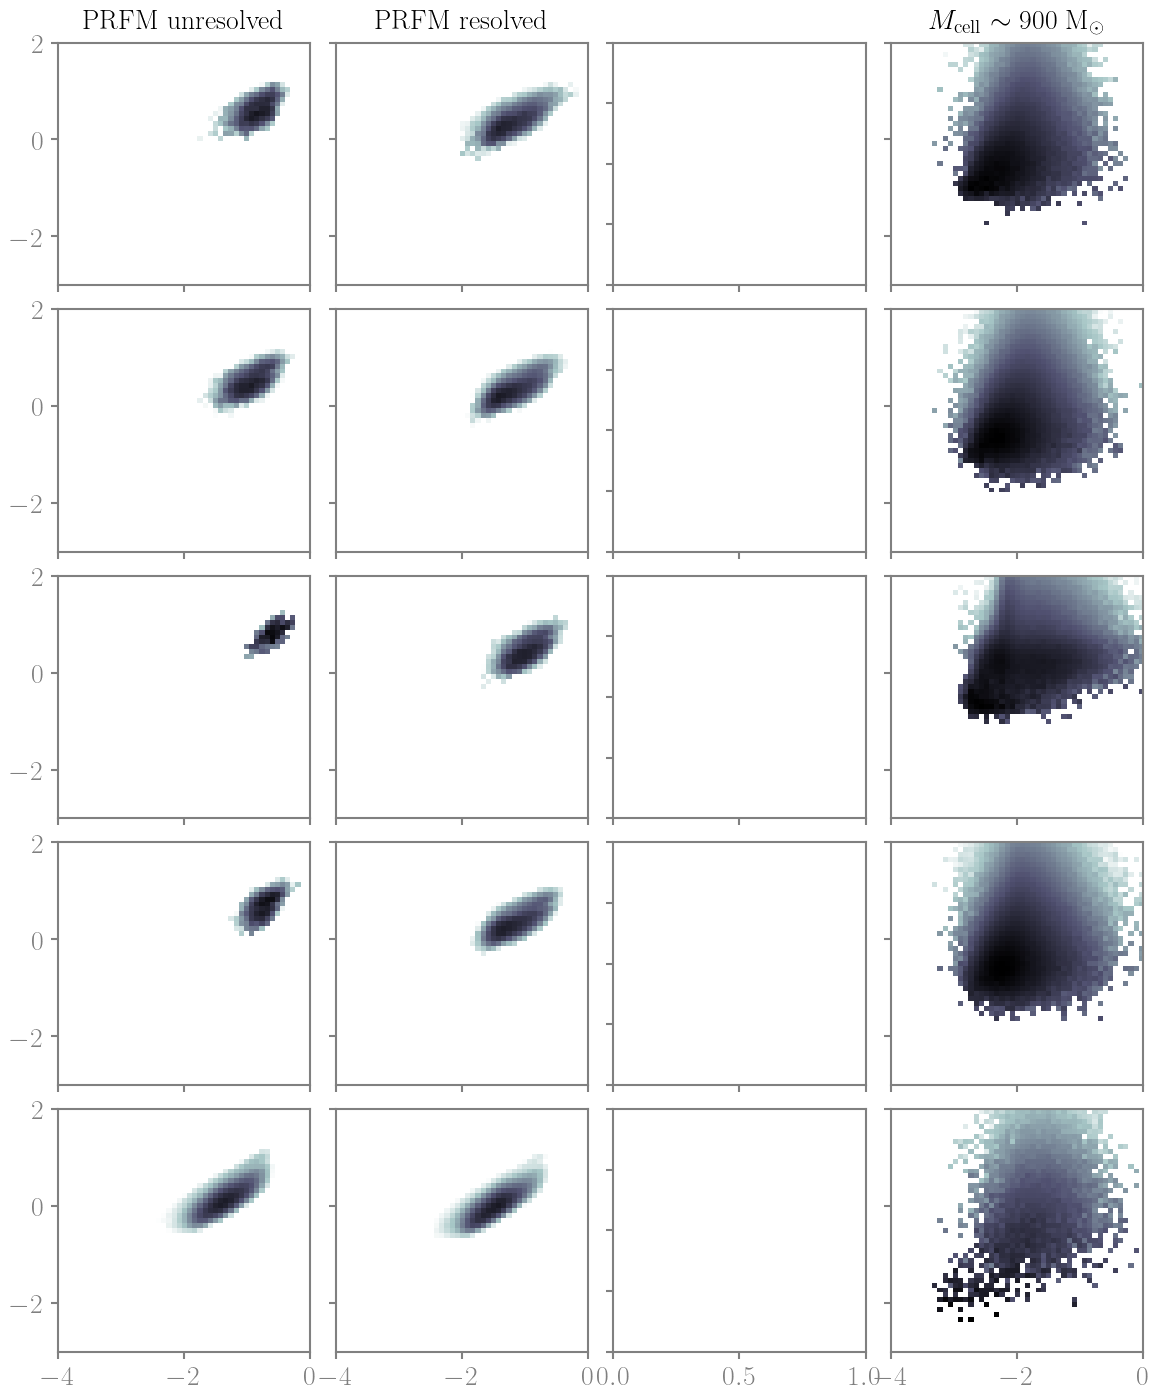

In [15]:
# 2D histogram of tau_dyn (x-axis) vs. tau_dep (y-axis) for PRFM and control (SH03) case,
# on two separate axes
fig, ax = plt.subplots(5, 4, figsize=(14, 17))

# PRFM unresolved
for i in range(5):
    tau_deps, tau_dyns, SFRs = tau_deps_PRFM[i], tau_dyns_PRFM[i], SFRs_PRFM[i]
    frac_SFR, _, _, _ = binned_statistic_2d(
        np.log10(tau_dyns), np.log10(tau_deps),
        SFRs, statistic='sum',
        bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
    )
    frac_SFR /= np.sum(frac_SFR)
    frac_SFR /= np.sum(frac_SFR)
    ax[i,0].imshow(frac_SFR.T, origin='lower',
                    extent=(-4., 0., -3., 2.), aspect='auto',
                    cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[0,0].set_title('PRFM unresolved', pad=10, fontsize=20)

# PRFM resolved
for i in range(5):
    tau_deps, tau_dyns, SFRs = tau_deps_PRFM_r[i], tau_dyns_PRFM_r[i], SFRs_PRFM_r[i]
    frac_SFR, _, _, _ = binned_statistic_2d(
        np.log10(tau_dyns), np.log10(tau_deps),
        SFRs, statistic='sum',
        bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
    )
    frac_SFR /= np.sum(frac_SFR)
    frac_SFR /= np.sum(frac_SFR)
    ax[i,1].imshow(frac_SFR.T, origin='lower',
                    extent=(-4., 0., -3., 2.), aspect='auto',
                    cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
ax[0,1].set_title('PRFM resolved', pad=10, fontsize=20)

# # SH03
# for i in range(5):
#     tau_deps, tau_dyns, SFRs = tau_deps_SH03[i], tau_dyns_SH03[i], SFRs_SH03[i]
#     frac_SFR, _, _, _ = binned_statistic_2d(
#         np.log10(tau_dyns), np.log10(tau_deps),
#         SFRs, statistic='sum',
#         bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
#     )
#     frac_SFR /= np.sum(frac_SFR)
#     frac_SFR /= np.sum(frac_SFR)
#     ax[i,2].imshow(frac_SFR.T, origin='lower',
#                     extent=(-4., 0., -3., 2.), aspect='auto',
#                     cmap=plt.cm.bone_r, norm=LogNorm(vmin=1.e-4, vmax=1.e-1))
# ax[0,2].set_title('SH03', pad=10, fontsize=20)

# high-resolution
for i in range(5):
    tau_deps, tau_dyns, SFRs = tau_deps_hr[i], tau_dyns_hr[i], Sigma_SFRs_hr[i]
    # bin the tau_dep in terms of the tau_dyn, weighted by SFR
    # use binned_statistic
    tau_dep_1d, bins = binned_statistic(
        np.log10(tau_dyns/ah.kB_cgs/ah.Gyr_to_s), np.log10(tau_deps/ah.Gyr_to_s),
        statistic=np.nanmean, bins=10)

    frac_SFR, _, _, _ = binned_statistic_2d(
        np.log10(tau_dyns/ah.kB_cgs/ah.Gyr_to_s), np.log10(tau_deps/ah.Gyr_to_s),
        SFRs, statistic='sum',
        bins=(np.linspace(-4., 0., 50), np.linspace(-3., 2., 50))
    )
    frac_SFR /= np.sum(frac_SFR)
    frac_SFR /= np.sum(frac_SFR)
    ax[i,3].imshow(frac_SFR.T, origin='lower',
                    extent=(-4., 0., -3., 2.), aspect='auto',
                    cmap=plt.cm.bone_r, norm=LogNorm())
ax[0,3].set_title(r'$M_{\rm cell} \sim 900~{\rm M}_\odot$', pad=10, fontsize=20)

# remove y-labels
for i in range(1, 4):
    for j in range(5):
        ax[j,i].set_yticklabels([])
# remove x-labels
for i in range(4):
    for j in range(4):
        ax[j,i].set_xticklabels([])

plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()